# MICrONS Co-registration and Visualization

This notebook uses the `dandi`-hosted [MICrONS functional data](https://dandiarchive.org/dandiset/000402/draft) and `bossdb`-hosted [MICrONS structural data](https://bossdb.org/microns/minnie) to examine and visualize the co-registered cells.


In [1]:
from dandi.dandiapi import DandiAPIClient
from caveclient import CAVEclient

from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO
from pynwb.file import NWBFile

from tqdm import tqdm
import pandas as pd

from pynwb.ophys import PlaneSegmentation
import matplotlib.pyplot as plt
import random


### Open the CAVE table with the structural / functional coregistration metadata

The table below lists metadata for each neuron nucleus id which has been coregistered with a functional unit id. The `target_id` field is unique to a specific neuron. The `session`, `scan_idx`, and `unit_id` fields can be used to match a nucleus id to a functional mask ID.

In [2]:
cave = CAVEclient("minnie65_phase3_v1")
coreg = cave.materialize.query_table("apl_functional_coreg_forward_v5")
coreg

,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,67007,2023-04-06 15:05:50.491194+00:00,t,255686,9,6,1913,2,8.941486,4.206369,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
1,65810,2023-04-06 15:05:49.502144+00:00,t,255686,9,4,7548,6,9.380808,-5.165012,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
2,54982,2023-04-06 15:05:15.938520+00:00,t,255686,8,7,4778,4,3.763804,5.341737,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
3,46412,2023-04-06 15:04:43.197444+00:00,t,255686,7,5,1946,2,4.071072,3.306988,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
4,11823,2023-04-06 15:03:01.038836+00:00,t,255686,5,3,1994,2,5.419972,6.644126,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68868,47300,2023-04-06 15:04:43.976991+00:00,t,327774,7,5,4482,4,16.224096,1.250938,327774,2020-09-28 22:44:36.355507+00:00,t,266.778542,91911819501110624,864691136194882892,"[197360, 137344, 18252]","[nan, nan, nan]","[nan, nan, nan]"
68869,807,2023-04-06 15:02:27.590327+00:00,t,327774,4,7,3042,4,5.542680,4.766722,327774,2020-09-28 22:44:36.355507+00:00,t,266.778542,91911819501110624,864691136194882892,"[197360, 137344, 18252]","[nan, nan, nan]","[nan, nan, nan]"
68870,58294,2023-04-06 15:05:18.878487+00:00,t,586003,8,9,5324,4,10.293441,0.803485,586003,2020-09-28 22:44:34.849907+00:00,t,265.097871,110702130159196825,864691135082420215,"[334352, 151008, 22252]","[nan, nan, nan]","[nan, nan, nan]"
68871,44547,2023-04-06 15:04:41.642611+00:00,t,586003,7,4,9559,6,3.757999,5.879896,586003,2020-09-28 22:44:34.849907+00:00,t,265.097871,110702130159196825,864691135082420215,"[334352, 151008, 22252]","[nan, nan, nan]","[nan, nan, nan]"


### Open the metadata table for the functional recording

This table has been pulled from a [DataJoint](https://datajoint.com/) database for convenience. The extra step is necessary because the dandiset identifies neurons by their mask IDs, not their unit IDs. Unit IDs are unique across a Dandi NWB file while mask IDs are unique within a field.

In [3]:
scan_units = pd.read_pickle("./ScanUnit.pkl")
scan_units

,session,scan_idx,unit_id,field,mask_id,um_x,um_y,um_z,px_x,px_y,ms_delay
0,4,7,1,1,1,-778,-771,80,7,5,0
1,4,7,2,1,2,-741,-766,80,22,7,0
2,4,7,3,1,3,-691,-776,80,41,3,0
3,4,7,4,1,4,-691,-766,80,42,8,0
4,4,7,5,1,5,-702,-767,80,37,7,0
...,...,...,...,...,...,...,...,...,...,...,...
168966,9,6,5503,4,1411,403,-24,175,368,414,95
168967,9,6,5504,4,1412,377,279,175,352,596,103
168968,9,6,5505,4,1413,403,106,175,368,493,98
168969,9,6,5506,4,1414,403,-244,175,368,283,90


### Open the dandiset of interest

The Microns two-photon calcium scans are found in dandiset 000402. All sessions and scans can be browsed at https://dandiarchive.org/dandiset/000402/0.230307.2132/files?location=. We will choose an entry at random from the coregistration table and open the NWB file which holds its functional data.

In [4]:
coreg_row = random.randint(1, len(coreg))
scan_unit_row = scan_units.loc[coreg_row]

dandiset_id = "000402"
session_no = scan_unit_row["session"]
scan_no = scan_unit_row["scan_idx"]
unit_id = scan_unit_row["unit_id"]
display((session_no, scan_no, unit_id))

(4, 9, 1955)

Since each file is tens of GB large, use the NWB streaming capability to open the file without reading all of it into memory at once, as explained at https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html.

In [5]:
# Get the location of the file on DANDI
def get_NWBFile(session_no, scan_no):
    file_path = f"sub-17797/sub-17797_ses-{session_no}-scan-{scan_no}_behavior+image+ophys.nwb"
    with DandiAPIClient() as client:
        asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

    # First, create a virtual filesystem based on the http protocol
    fs = filesystem("http")

    # Create a cache to save downloaded data to disk (optional)
    fs = CachingFileSystem(
        fs=fs,
        cache_storage="nwb-cache",  # Local folder for the cache
    )

    # Next, open the file with NWBHDF5IO
    file_system = fs.open(s3_url, "rb")
    file = File(file_system, mode="r")
    io = NWBHDF5IO(file=file, load_namespaces=True)

    microns_data = io.read()
    return microns_data

microns_data = get_NWBFile(session_no, scan_no)

A newer version (0.56.1) of dandi/dandi-cli is available. You are using 0.56.0
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Update the NWB File

The `NWBFile` object contains all the metadata associated with the dandiset. The attribute `processing -> ophys -> data_interfaces -> plane_segmentations` contains the structural ids associated with the image masks. The first step this notebook will take is to update each `PlaneSegmentation` object using the new structural ids which were published in 2023. These are found in the CAVE table `apl_functional_coreg_forward_v5`, column `target_id`. While we're in there, also add the unit IDs as a column.


In [6]:
# TODO: move these to another notebook and reference them here

def create_new_plane_segmentation(old, df, descriptions):
    ps = PlaneSegmentation(
        name=old.name, 
        description=old.description, 
        imaging_plane=old.imaging_plane,
        id=df.index.tolist()
    )
    
    for col in df.columns:
        if col in old.colnames:
            old_col = find_column_by_name(old, col)
            ps.add_column(name=old_col.name, description=old_col.description, data=df[col].tolist())
        else:
            ps.add_column(name=col, description=descriptions[col], data=df[col].tolist())
    return ps
        

def find_column_by_name(table,col_name):
    for c in table.columns:
        if c.name == col_name:
            return c

In [7]:
# FYI: I commented out the pickled coreg table so that it's always pulled from cave. I think we should remove it all the way to reduce confusion.

def update_microns_nwb_file(
    nwb: NWBFile,
    coreg,
    scan_units,
    add_scan_units_to_nwb=True,
    
):
        
    session, scan_idx = int(nwb.session_id.split('-')[0]), int(nwb.session_id.split('-')[2])
    if session == 5 and scan_idx == 7:
        print("Error: This file does not contain a unit_id column")
        return 
    scan_units_modified = scan_units[(scan_units['session']==session) & (scan_units['scan_idx']==scan_idx)]
    
    image_segmentation = nwb.processing["ophys"].data_interfaces["ImageSegmentation"]
    
    all_ps = list(image_segmentation.plane_segmentations)
    for ps_name in tqdm(all_ps):
        
        ps = image_segmentation.plane_segmentations.pop(ps_name)
        field = int(ps_name[-1])
        field_scan_units = scan_units_modified[scan_units_modified['field'] == field]
        ps_df = ps[:]
        ps_df['mask_id'] = ps_df.index
        ps_df_with_units = ps_df.merge(field_scan_units, on='mask_id', how='left').drop(columns=[
            'mask_id', 'session', 'scan_idx', 'field'
        ])
        
        coreg_units = coreg[
            (coreg['session']==session) & 
            (coreg['scan_idx']==scan_idx) & 
            (coreg['field'] == field)
        ][['target_id', 'unit_id']]
        
        if len(coreg_units):
            ps_df_with_units = ps_df_with_units.merge(coreg_units, on='unit_id').rename(
                columns={
                    'target_id': 'auto_match_cave_nuclei_id', 
                    'cave_ids': 'manual_match_cave_nuclei_id'
                }
            )
        
        description = {x: "Placeholder" for x in ps_df_with_units.columns}
        new_ps = create_new_plane_segmentation(ps, ps_df_with_units, description)
        image_segmentation.plane_segmentations.add(new_ps)
        
    return nwb

In [8]:
# microns_data = update_microns_nwb_file(microns_data, used_cache_coregistration_table=False)
microns_data = update_microns_nwb_file(microns_data, coreg, scan_units)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.25s/it]


### Visualization

The functional data contains multiple types of data for a single mask ID. Plot the image of the mask and its fluorescence trace together.

In [9]:
# Return the mask image, fluorescence trace values, and timestamps for a given unit id
def get_time_series_data(unit_id):
    mask_id = 0
    for plane_seg in range(1, 9):
        image_seg = microns_data.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations[f"PlaneSegmentation{plane_seg}"]
        try:
            mask_id = image_seg.get("unit_id").data.index(unit_id)
        except:
            continue
        else:
            break

    if mask_id == 0:
        return Exception(f"Unit Id {unit_id} not found")

    # Get fluorescence of the table number
    fluor = microns_data.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series[f"RoiResponseSeries{plane_seg}"]

    # Pull the data we are interested in
    mask_image = image_seg.image_mask[mask_id]
    fluor_data = fluor.data[:, mask_id]
    timestamps = fluor.timestamps[:]

    return mask_image, fluor_data, timestamps

Text(0, 0.5, 'response magnitude')

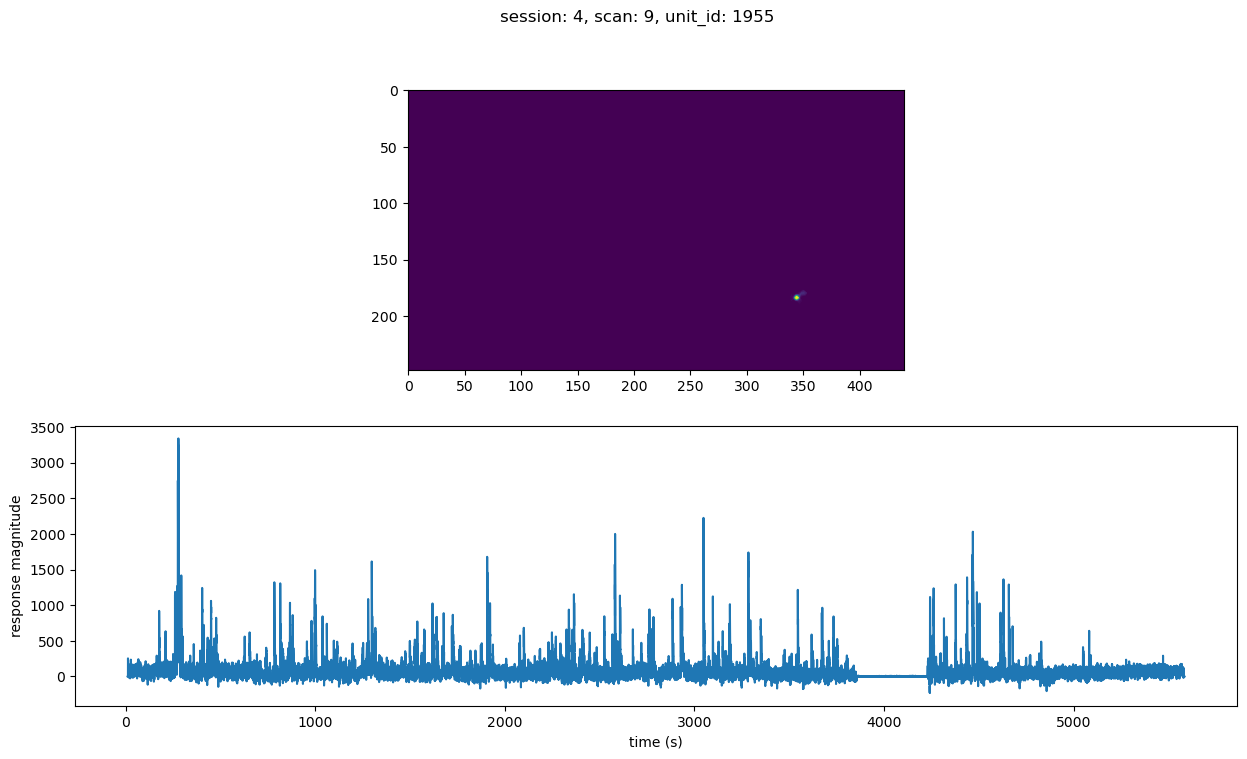

In [10]:
# Plot the segmentation and fluorescence trace for the unit id
mask_image, fluor, timestamps = get_time_series_data(unit_id)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle(f'session: {session_no}, scan: {scan_no}, unit_id: {unit_id}')
ax1.imshow(mask_image)
ax2.plot(timestamps, fluor)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("response magnitude")

### Connectivity-informed functional analysis

We can use the `pt_root_id` column in the coregistration table we pulled at the very beginning of the notebook to generate a list of neurons which synapse onto our neuron of interest, along with the quantity and pre/post designation of each synapse.

In [11]:
def generate_synapse_map(pt_root_id):
    return {
        'pre': cave.materialize.query_table("synapses_pni_2", 
            filter_equal_dict={"post_pt_root_id": str(pt_root_id)})['pre_pt_root_id'].value_counts().to_dict(),
        'post': cave.materialize.query_table("synapses_pni_2", 
            filter_equal_dict={"pre_pt_root_id": str(pt_root_id)})['post_pt_root_id'].value_counts().to_dict()
    }

pt_root_id = coreg.iloc[coreg_row]["pt_root_id"]
synapse_map = generate_synapse_map(pt_root_id)

# Remove neuron cycles first if they exist.
del synapse_map['pre'][pt_root_id]
del synapse_map['post'][pt_root_id]

In [12]:
# Find a functionally characterized neuron in the list of post synaptic neurons
for post_pt_root_id in synapse_map['post']:
    coreg_row_2 = coreg.loc[coreg["pt_root_id"] == post_pt_root_id].head(1)
    if len(coreg_row_2) > 0: break
    
# Repeat the steps to pull the NWB file for the neuron
scan_unit_row_2 = scan_units.loc[coreg_row_2.index[0]]

session_no_2 = scan_unit_row_2["session"]
scan_no_2 = scan_unit_row_2["scan_idx"]
unit_id_2 = scan_unit_row_2["unit_id"]

microns_data_2 = get_NWBFile(session_no_2, scan_no_2)
microns_data_2 = update_microns_nwb_file(microns_data_2, coreg, scan_units)
microns_data_2

/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

root pynwb.file.NWBFile at 0x6108050960
Fields:
  acquisition: {
    EyeTracking <class 'pynwb.behavior.EyeTracking'>,
    PupilTracking <class 'pynwb.behavior.PupilTracking'>,
    TwoPhotonSeries1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries3 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries4 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries5 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries6 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries7 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries8 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Video: stimulus_17797_4_9_v4 <class 'pynwb.image.ImageSeries'>,
    treadmill_velocity <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: The light microscopic images were acquired from a cubic millimeter volume that spanned portions of primary visual cortex and three higher visual cortical areas. The volume was imaged in vivo by two-photon random access mesoscope (2P-RAM) from postnatal days P75 to P81 in a male mouse expressing a genetically encoded calcium indicator in excitatory cells, while the mouse viewed natural movies and parametric stimuli. The calcium imaging data includes the single-cell responses of an estimated 75,000 pyramidal cells imaged over a volume of approximately 1200 x 1100 x 500 μm3 (anteroposterior x mediolateral x radial depth). The center of the volume was placed at the junction of primary visual cortex (VISp) and three higher visual areas, lateromedial area (VISlm), rostrolateral area (VISrl) and anterolateral area (VISal). During imaging, the animal was head-restrained, and the stimulus was presented to the left visual field. Treadmill rotation (single axis) and video of the animal's left eye were captured throughout the scan, yielding the locomotion velocity, eye movements, and pupil diameter data included here. The functional data were co-registered with electron microscopy (EM) data. The structural identifiers of the matched cells are added as plane segmentation columns extracted from the CAVE database. To access the latest revision see the notebook that is linked to this dandiset. The structural ids might not be present for all plane segmentations.
  file_create_date: [datetime.datetime(2023, 2, 12, 21, 42, 50, 494421, tzinfo=tzutc())]
  identifier: 5826ca3a-35cc-43f6-b63b-24280a2ad602
  imaging_planes: {
    ImagingPlane1 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane2 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane3 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane4 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane5 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane6 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane7 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane8 <class 'pynwb.ophys.ImagingPlane'>
  }
  intervals: {
    Clip <class 'pynwb.epoch.TimeIntervals'>,
    Monet2 <class 'pynwb.epoch.TimeIntervals'>,
    Trippy <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1101/2021.07.28.454025']
  session_description: Contains calcium imaging recorded from multiple cortical visual areas and behavioral measurements while a mouse viewed natural movies and parametric stimuli. The structural ids are added as plane segmentation columns from the CAVE database on 2023-02-12. To access the latest revision see the notebook that is linked to the dandiset. The structural ids might not be present for all plane segmentations.
  session_id: 4-scan-9
  session_start_time: 2018-03-04 00:00:00+00:00
  subject: subject pynwb.file.Subject at 0x5754857808
Fields:
  age: P75D/P81D
  sex: M
  species: Mus musculus
  subject_id: 17797

  timestamps_reference_time: 2018-03-04 00:00:00+00:00

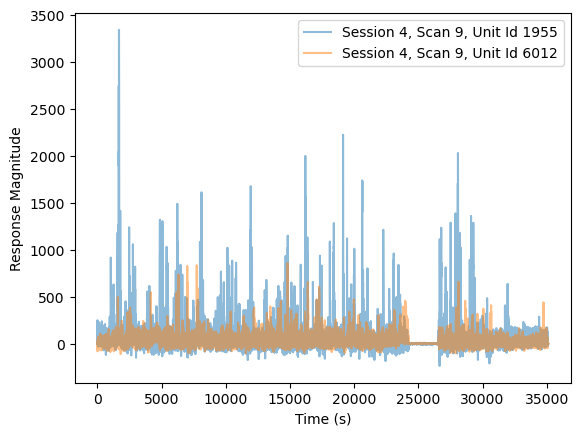

In [13]:
# Plot the two functional traces on top of each other

mask_image2, fluor2, timestamps2 = get_time_series_data(unit_id_2)

plt.plot(fluor, label=f"Session {session_no}, Scan {scan_no}, Unit Id {unit_id}", alpha=0.5)
plt.plot(fluor2, label=f"Session {session_no_2}, Scan {scan_no_2}, Unit Id {unit_id_2}", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Response Magnitude")
plt.legend()